In [1]:
%matplotlib inline

In [22]:
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables
from matplotlib.mlab import PCA
import sklearn
import seaborn as sns
from collections import defaultdict
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from __future__ import division
import tqdm

In [ ]:
#insert path to non enriched deep sequencing molecule info H5 file from 10X pipeline
c_path='/../molecule_info.h5'
control=Read10x(c_path)

In [3]:
np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")
def Read10x(filepath):   
    with tables.open_file(filepath, 'r') as f:
        try:
            group = f.get_node(f.root)
        except tables.NoSuchNodeError:
            print "That genome does not exist in this file."
        gene_ids = getattr(group, 'gene_ids').read()
        gene_names = getattr(group, 'gene_names').read()
        gene = getattr(group, 'gene').read()
        umi_corrected_reads=getattr(group, 'umi_corrected_reads').read()
        nonconf_mapped_reads=getattr(group, 'nonconf_mapped_reads').read()
        conf_mapped_uniq_read_pos=getattr(group, 'conf_mapped_uniq_read_pos').read()
        unmapped_reads=getattr(group, 'unmapped_reads').read()
        barcodes = getattr(group, 'barcode').read()
        reads = getattr(group, 'reads').read()
        umi = getattr(group, 'umi').read()

        TABLE=pd.DataFrame()
        TABLE['bc']=barcodes
        TABLE['umi']=umi
        #TABLE['bcumi']=zip(barcodes,umi)
        TABLE['gene']=gene
        TABLE['unique']=[1]*len(TABLE)
        TABLE['map_logical']=conf_mapped_uniq_read_pos>0
        TABLE['read_counts']=reads+nonconf_mapped_reads+unmapped_reads
        return TABLE

def get_gene(BC,df_1):
    Total=df_1.gene[df_1.bc==BC].value_counts().to_frame()
    Total.columns=['Counts']
    genes1=np.zeros(32739)
    for index,rows in Total.iterrows():
        genes1[index]=rows['Counts']
    return genes1[:-1]
def setenv(newDict):
    #Switch between 10X sequence barcode and 2-bit encoded barcode 
    DNA={}
    DNA['A']='00'
    DNA['C']='01'
    DNA['G']='10'
    DNA['T']='11'

    BC_DNA2={}
    for i in newDict.iterkeys(): 
        string=newDict[i]
        for j in DNA.iterkeys():
            string=string.replace(j,DNA[j])
        BC_DNA2[i]=int(string,2)
    return BC_DNA2

def hamming_distance(s1, s2):
    #Return the Hamming distance between equal-length sequences
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))


In [4]:
#CD_19, insert gene expression profile path
#filtered_matrix_h5='/.../filtered_gene_bc_matrices_h5.h5'

#HLA_DR, insert gene expression profile path
filtered_matrix_h5='/../filtered_gene_bc_matrices_h5.h5'

genome = "hg19"

#load expression profile
%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)

CPU times: user 115 ms, sys: 26.1 ms, total: 141 ms
Wall time: 165 ms


In [5]:
#Create dataframe of cell barcodes vs expression
gnames=gene_bc_matrix.gene_names
cnames=gene_bc_matrix.barcodes
DGE=pd.DataFrame(gene_bc_matrix.matrix.toarray())
DGE.index=gnames
DGE.columns=cnames
cumi=DGE.sum() # number of UMIs per cell barcode

In [9]:
#get list of all barcode sequences
barcodes=defaultdict(str)
for index, item in enumerate(cnames):
        barcodes[index]=item[:-2]
        
#identify number of reads assigned to each barocde
Tot_BC=setenv(barcodes)
reads=defaultdict(int)
for k,v in Tot_BC.iteritems():
    reads[v]=control[control.bc==v]['read_counts'].sum()

In [6]:
newDict = {}
#insert path to barcode text file
with open('/../enriched_barcodes.txt', 'r') as f:
    for line in f:
        splitLine = line.split(',')
        newDict[int(splitLine[0])] = splitLine[1][:-1]
BC=setenv(newDict)

In [7]:
#HLA-DR 


list_a=[4,5,6,7,8,9]
list_b=[12,13,14,15,16,17,30,31,32,33]
list_c=[34,35,37,38,39,40,41,42,43]
list_d=[44,45,46,47,48,49,50,51,52,53]
list_e=[54,55,56,57,58,59,60,61,62,63,64,65,66,67,68]

#All barcodes combined in one list
list_f=[4,5,6,7,8,9,12,13,14,15,16,17,30,31,32,33,34,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63,64,65,68]

In [8]:
#load gene expression matrix
enrich=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/Gene_expression/HLA_DR_Gene_expression_matrix.h5',key='10X').T
enrich2=enrich.copy()

#identify 10X barcode number, filter threshold, and barcode sequence
enrich2['bc']=[newDict[int(x.split('_')[0])]+'-1' for x in enrich2.index]
enrich2['filter']=[int(x.split('_')[2]) for x in enrich2.index]
enrich2['BC']=[int(x.split('_')[0]) for x in enrich2.index]

In [9]:
#format barcode string to be compatible with 10X structure
bc_=defaultdict(str)
for a in list_c:
    bc_[a]=newDict[a]+'-1'

In [10]:
colors=['#000000','#800000','#FF0000','#AA6E28','#FF9900','#808000','#FFEA00','#BEFF00','#00BE00','#008080','#64FFFF','#000080','#4385FF','#820096','#FF00FF',"#e07b91", "#d33f6a", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0","#483d8b","#ffa500","#ba55d3",'#000000','#800000','#FF0000','#AA6E28','#FF9900','#808000','#FFEA00','#BEFF00','#00BE00','#008080','#64FFFF','#000080','#4385FF','#820096','#FF00FF',"#e07b91", "#d33f6a", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0","#483d8b","#ffa500","#ba55d3"]

In [11]:
#AS DC specific genes
genes=['AXL','PPP1R14A','SIGLEC6','CD22','DAB2','S100A10','FAM105A','MED12L','ALDH2','LTK']

In [12]:
#gene expression of AS DC classifier genes in enriched data set
e_sam=enrich2[['AXL','PPP1R14A','SIGLEC6','CD22','DAB2','S100A10','FAM105A','MED12L','ALDH2','LTK','bc']][(enrich2['filter']==3)&(enrich2.BC.isin(list_c))].sort_index()
e_sam2=e_sam[genes] #only get the genes in dataframe

#Gene expression profiles in non enriched data for target barcodes
c_sam=DGE.loc[['AXL','PPP1R14A','SIGLEC6','CD22','DAB2','S100A10','FAM105A','MED12L','ALDH2','LTK']][bc_.values()].T

#Gene expression profiles in non enriched data for all non target barcodes
All=DGE.loc[['AXL','PPP1R14A','SIGLEC6','CD22','DAB2','S100A10','FAM105A','MED12L','ALDH2','LTK']].T

In [13]:
#define fraction of cell that have expression of AS DC classifiers for the above datasets

all_frac=[All[All[x]>0].shape[0]/All.shape[0] for x in genes]
e_frac=[e_sam[e_sam[x]>0].shape[0]/e_sam.shape[0] for x in genes]
c_frac=[c_sam[c_sam[x]>0].shape[0]/c_sam.shape[0] for x in genes]

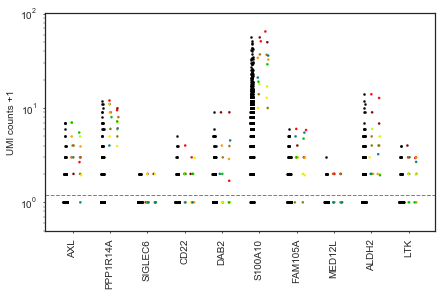

In [18]:
#plotting code
fig,ax=plt.subplots(figsize=(7,4))#2.5,2.5
sns.set(style='white')
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})


s1=5
wiggle=.3
position1=np.arange(10)*20
position2=position1+4
position3=position1+8

plt.xticks(position2,genes,rotation=90)
for i,d in enumerate(All):
    y = All[d]+1
    x = np.random.normal(position1[i], wiggle, len(y))
    plt.scatter(x,y,s=s1,c='k')
    
for i,d in enumerate(c_sam):
    y = c_sam[d]+1
    x = np.random.normal(position2[i], wiggle+.1, len(y))
    plt.scatter(x,y,s=s1,c=colors[1:10])
    
for i,d in enumerate(e_sam2):
    y = e_sam2[d]+1
    x = np.random.normal(position3[i], wiggle+.1, len(y))
    plt.scatter(x,y,s=s1,c=colors[1:10])

    
plt.ylim([.5,101])
plt.axhline(1.2,ls='dashed',lw=1,color='gray')
#plt.xlim([-.25,1.75])
#plt.xlabel('')
plt.ylabel('UMI counts +1')
plt.yscale('log')
#sns.despine()
ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=2)

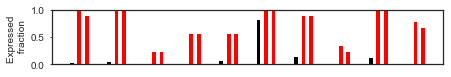

In [19]:
fig,ax=plt.subplots(figsize=(7,1))#2.5,2.5
sns.set(style='white')
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})

w=2
plt.bar(position1,all_frac,width=w,color='k')
plt.bar(position2,c_frac,width=w,color='r')
plt.bar(position3,e_frac,width=w,color='r')
#sns.despine()
#plt.yticks([.01,.1,1],[.01,.1,1])
plt.ylim([.0005,1])
#plt.yscale('log')
plt.ylabel('Expressed \n fraction')
plt.xticks([])
ax.tick_params(axis=u'both', which=u'both',length=2)

/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5,1,u'Enriched library')

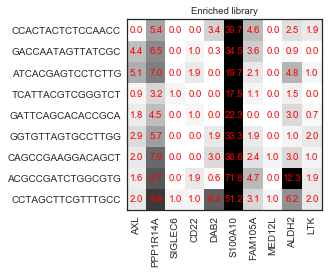

In [20]:
fig,ax=plt.subplots(figsize=(3.5,3.5))

temp=enrich[genes][(enrich2['filter']==1)&(enrich2.BC>33)&(enrich2.BC<44)&(enrich2.BC!=36)].sort_index()
temp2=enrich2[['AXL','PPP1R14A','SIGLEC6','CD22','DAB2','S100A10','FAM105A','MED12L','ALDH2','LTK','bc']][(enrich2['filter']==1)&(enrich2.BC>33)&(enrich2.BC<44)&(enrich2.BC!=36)].sort_index()

sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})

plt.pcolor(temp[genes],vmin=0,vmax=12,cmap='Greys')
plt.yticks(np.arange(0.5, len(temp[genes].index), 1), [x[:-2] for x in temp2.bc])
plt.xticks(np.arange(0.5, len(temp[genes].columns), 1), temp[genes].columns)
for y in range(len(temp.index)):
    for x in range(len(genes)):
        plt.text(x + 0.5, y + 0.5, '%.1f' % float(temp.ix[y][genes[x]]),
                 horizontalalignment='center',
                 verticalalignment='center',color='r'
                 )

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.title('Enriched library')


/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


Text(0.5,1,u'Original library')

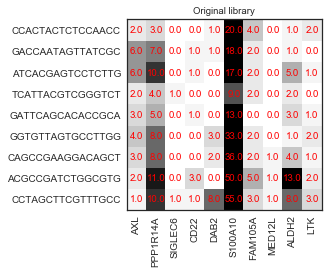

In [21]:
fig,ax=plt.subplots(figsize=(3.5,3.5))
temp3=DGE.loc[genes][[newDict[x]+'-1' for x in list_c]].T

sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})

plt.pcolor(temp3[genes],vmin=0,vmax=12,cmap='Greys')
plt.yticks(np.arange(0.5, len(temp3[genes].index), 1), [x[:-2] for x in temp3.index])
plt.xticks(np.arange(0.5, len(temp3[genes].columns), 1), temp3[genes].columns)
for y in range(len(temp3.index)):
    for x in range(len(genes)):
        plt.text(x + 0.5, y + 0.5, '%.1f' % float(temp3.ix[y][genes[x]]),
                 horizontalalignment='center',
                 verticalalignment='center',color='r'
                 )

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.title('Original library')



In [ ]:
#down sample original deep sequenced data to determine expression of genes at lower sequencing effort
flag=0
list_c=[34,35,37,38,39,40,41,42,43]
for i in tqdm.tqdm_notebook(range(1000),desc='0th'):
    temp_dict=defaultdict()
    temp_s=control.sample(int(1300000),weights=control.read_counts,replace=True)
    for item in tqdm.tqdm_notebook(list_c,desc='1st',leave=False):
        temp_dict[newDict[item]]=get_gene(BC[item],temp_s)
        
        if flag==0:
            new_df=pd.DataFrame.from_dict(temp_dict,orient='index')
            new_df.columns=gnames
            new_df=new_df[genes]
            flag=1
        elif flag==1:
            temp_df=pd.DataFrame.from_dict(temp_dict,orient='index')
            temp_df.columns=gnames
            temp_df=temp_df[genes]
            new_df=pd.concat([new_df,temp_df])
new_df=gnames

In [218]:
#identify average expression for each of the genes from downsampled data
ne=defaultdict()
for item in list_c:
    tempt=new_df.loc[newDict[item]]
    ne[item]=tempt.mean(axis=0).values
    

In [219]:
ne2=pd.DataFrame.from_dict(ne,orient='index')
ne2.columns=new_df.columns

/Users/nranu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


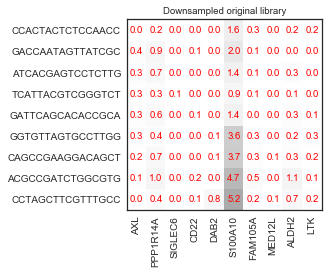

In [229]:
fig,ax=plt.subplots(figsize=(3.5,3.5))
temp3=ne2.copy()

sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})

plt.pcolor(temp3[genes],vmin=0,vmax=12,cmap='Greys')
plt.yticks(np.arange(0.5, len(temp3[genes].index), 1), [newDict[x] for x in list_c])
plt.xticks(np.arange(0.5, len(temp3[genes].columns), 1), temp3[genes].columns)
for i,y in enumerate(temp3.index):
    for x in range(len(genes)):
        plt.text(x + 0.5, i + 0.5, '%.1f' % float(temp3.ix[y][genes[x]]),
                 horizontalalignment='center',
                 verticalalignment='center',color='r'
                 )

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.title('Downsampled original library')
